In [87]:
import itertools
from collections import Counter
import pandas as pd
from tqdm import tqdm
import numpy as np
import datetime as dt
from tqdm import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, log_loss, classification_report, make_scorer, roc_curve, roc_auc_score
from lightgbm import LGBMClassifier, plot_importance
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from category_encoders import TargetEncoder, CatBoostEncoder, WOEEncoder
from sklearn.pipeline import Pipeline
import eli5
from eli5.sklearn import PermutationImportance

from functools import partial
from hyperopt import hp, fmin, tpe, Trials, space_eval
from hyperopt.pyll.base import scope

import warnings
warnings.filterwarnings('ignore')

In [88]:
TRAIN_PATH = '../input/new-autoinland-vehicle-insurance-claim-challenge/Train.csv'
TEST_PATH = '../input/new-autoinland-vehicle-insurance-claim-challenge/Test.csv'
SUBMISSION_PATH = '../input/new-autoinland-vehicle-insurance-claim-challenge/SampleSubmission.csv'
NIGERIAN_STATES = '../input/new-autoinland-vehicle-insurance-claim-challenge/NigerianStateNames.csv'
VARIABLE_DEFN = '../input/new-autoinland-vehicle-insurance-claim-challenge/VariableDefinitions.csv'

In [89]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
nigerian_states = pd.read_csv(NIGERIAN_STATES)
variables = pd.read_csv(VARIABLE_DEFN)
submission = pd.read_csv(SUBMISSION_PATH)

In [90]:
train.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1


In [91]:
test.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,ID_01QM0NU,2010-10-23,2011-10-22,Female,46,2010-10-23,1,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic
1,ID_024NJLZ,2010-10-14,2011-10-13,Male,32,2010-10-14,1,NaN,NaN,NaN,Kosofe,Benue,Car Classic
2,ID_02NOVWQ,2010-08-29,2011-08-28,Female,45,2010-08-29,2,Saloon,Black,Honda,Wuse 11,Abuja,Car Classic
3,ID_02VSP68,2010-06-13,2011-06-12,Female,58,2010-06-13,1,Saloon,NaN,TOYOTA,NaN,NaN,CarSafe
4,ID_02YB37K,2010-07-01,2011-06-30,NaN,120,2010-07-01,1,Saloon,Red,Hyundai,Victoria Island,Lagos,Car Classic


In [92]:
print(f'The shape of the train set is: {train.shape}\nThe shape of the test set is: {test.shape}')

The shape of the train set is: (12079, 14)
The shape of the test set is: (1202, 13)


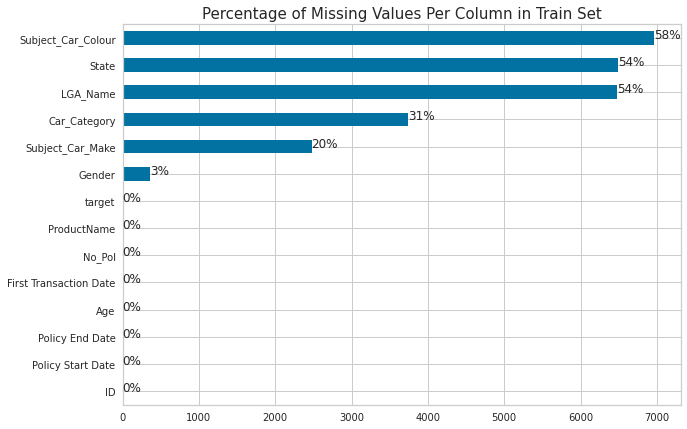

In [93]:
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

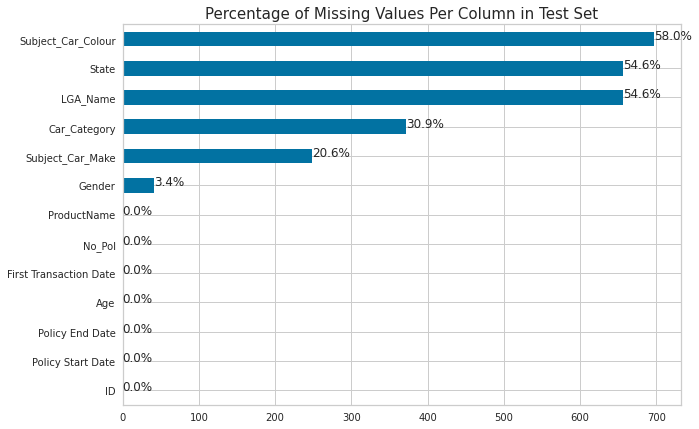

In [94]:
ax = test.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Test Set', fontdict={'size':15})

for p in ax.patches:
    percentage ='{:,.1f}%'.format((p.get_width()/test.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [ ]:
ddd = ['Policy Start Date', 'Policy End Date', 'ProductName', 'Age', 'No_Pol',\
       'Gender', 'Car_Category', 'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State']
d = train[train.duplicated(subset=ddd, keep=False)].sort_values(by=ddd+['target'])
d

In [ ]:
d[100:120]

In [ ]:
train = train.sort_values(by=ddd+['target']).drop_duplicates(subset=ddd, keep='last')
train = train.reset_index(drop=True)
train

In [ ]:
ntrain = train.shape[0] # to be used to split train and test set from the combined dataframe

all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

In [ ]:
all_data.tail()

In [ ]:
all_data.info()

In [ ]:
# Change each column to its appriopriate datatype
date_cols = [col for col in all_data.columns if 'Date' in col]
num_cols = ['Age', 'No_Pol']
cat_cols = [col for col in all_data.columns if col not in date_cols+num_cols+['ID', 'target']]

for col in all_data.columns:
    if col in date_cols:
        all_data[col] = pd.to_datetime(all_data[col])
#     elif col in cat_cols:
#         all_data[col] = all_data[col].astype('category')

# Confirm whether the changes have been applied successfully
all_data.info()

In [ ]:
sns.countplot(train.target)
plt.title('Target Distribution', fontdict={'size':14});

In [ ]:
ax = all_data.Gender.value_counts().sort_values().plot(kind = 'barh', figsize=(10,7))
plt.title('Gender Distribution', fontdict={'size': 15})
for p in ax.patches:
    percentage ='{:,.1f}%'.format((p.get_width()/all_data.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [ ]:
mapper = {'Entity':'Other', 'Joint Gender':'Other', 'NOT STATED':'Other', 'NO GENDER': 'Other', 'SEX':"Other"}
all_data.Gender = all_data.Gender.replace(mapper)

# Confirm mappings
all_data.Gender.value_counts()

In [ ]:
subject_car_colour_rename = {
    "Dark Grey": "Dark Gray",
    "D. Red": "Dark Red",
    "Gray & Gray": "Gray",
    "D. Gold": "Dark Gold",
    "Blue & Red": "Red & Blue",
    "Yellow & White": "White & Yellow",
    "White & Red": "Red & White",
}

subject_car_make_rename = {
#     ".": "OTHER",
    ".": np.nan,
    "Land Rover.": "Land Rover",
    "Wrangler Jeep": "Jeep"
}

states = {
#     "N-A": "OTHER",
    "N-A": np.nan,
}


all_data.State = all_data.State.replace(states)
all_data.Subject_Car_Colour = all_data.Subject_Car_Colour.replace(subject_car_colour_rename)
all_data.Subject_Car_Make = all_data.Subject_Car_Make.replace(subject_car_make_rename)


In [ ]:
all_data.Subject_Car_Colour.value_counts()

In [ ]:
for col in cat_cols:
    all_data[col] = np.where(all_data[col]=='As Attached', np.nan, all_data[col])
    all_data[col] = np.where(all_data[col]=='Other', np.nan, all_data[col])

In [ ]:
for col in cat_cols:
    print(col)
    print(all_data[col].unique(), '\n')

In [ ]:
for col in all_data.columns:
    if col not in ['ID', 'target']:
        all_data[col+"_imputed"] =   np.where(all_data[col].isna(),1,0)
        if col in date_cols+cat_cols:
            all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
        elif col in num_cols:
            all_data[col] = all_data[col].fillna(all_data[col].mean())

# Confirm that there aren't any missing values
all_data[all_data.columns.difference(['target'])].isna().sum()

In [ ]:

for col in ['Car_Category', 'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State']:
    all_data.loc[:, col] = all_data[col].apply(lambda x: x.lstrip())
    all_data.loc[:, col] = all_data[col].apply(lambda x: x.rstrip())
    
for col in ['Car_Category', 'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State', 'Gender']:
    all_data.loc[:, col] = all_data[col].apply(lambda x: str(x).lower())
    all_data.loc[:, col] = all_data[col].apply(lambda x: str(x).lower())
    
state_name = {
 'aba-north': 'abia-state',
 'aba-south': 'abia-state',
 'abia': 'abia-state',
 'aboh-mbaise': 'imo-state',
 'abuja': 'capital-fct',
 'abuja-municipal': 'abuja-municipal-area-council',
 'abule-egba': 'alimosho',
 'ado-ekiti': 'ekiti-state',
 'ado-ota': 'ogun-state',
 'ajao-estate': 'oshodi-isolo',
 'ajegunle-state': 'lagos-state',
 'akoko-west': 'ondo-state',
 'akwa-ibom': 'state-akwa-ibom',
 'anambra': 'anambra-state',
 'anambra-east': 'anambra-state',
 'aniocha-south': 'delta-state',
 'asari-toru': 'rivers-state',
 'awka-north': 'anambra-state',
 'awka-south': 'anambra-state',
 'bauchi': 'bauchi-state',
 'bayelsa': 'bayelsa-state',
 'benue': 'benue-state',
 'calabar-municipality': 'cross-river-state',
 'central-abuja': 'capital-fct',
 'cross-river': 'cross-river-state',
 'delta': 'delta-state',
 'ebonyi': 'ebonyi-state',
 'edo': 'edo-state',
 'ekiti-east': 'ekiti-state',
 'ekiti-west': 'ekiti-state',
 'enugu-north': 'enugu-state',
 'enugu-south': 'enugu-state',
 'esan-central': 'edo-state',
 'esan-west': 'edo-state',
 'essien-udim': 'akwa-ibom-state',
 'ethiope-east': 'delta-state',
 'etsako-west': 'edo-state',
 'gombe': 'gombe-state',
 'ibadan-east': 'oyo-state',
 'ibadan-north': 'oyo-state',
 'ibadan-west': 'oyo-state',
 'ibarapa-central': 'oyo-state',
 'idemili-north': 'anambra-state',
 'ifako-ijaye': 'ifako-ijaiye',
 'ife-north': 'osun-state',
 'ijebu-east': 'ogun-state',
 'ijebu-north': 'ogun-state',
 'ijebu-ode': 'ogun-state',
 'ile-oluji': 'ile-oluji-okeigbo',
 'ilesha-east': 'osun-state',
 'ilesha-west': 'osun-state',
 'ilorin-east': 'kwara-state',
 'ilorin-west': 'kwara-state',
 'imo': 'imo-state',
 'isoko-north': 'delta-state',
 'isoko-south': 'delta-state',
 'jos-north': 'plateau-state',
 'jos-south': 'plateau-state',
 'kaduna': 'kaduna-state',
 'kaduna-north': 'kaduna-state',
 'kaduna-south': 'kaduna-state',
 'kano': 'kano-state',
 'kano-municipal': 'kano-state',
 'kebbi': 'kebbi-state',
 'kogi': 'kogi-state',
 'kwara': 'kwara-state',
 'lagelu-north': 'oyo-state',
 'lagos': 'lagos-state',
 'nasarawa': 'nasarawa-state',
 'ndokwa-east': 'delta-state',
 'nnewi-south': 'anambra-state',
 'nsit-ubium': 'akwa-ibom-state',
 'obia-akpor': 'rivers-state',
 'ogba-ndoni': 'rivers-state',
 'ogbmosho-south': 'oyo-state',
 'ogun': 'ogun-state',
 'ogun-waterside': 'ogun-state',
 'ondo': 'ondo-state',
 'ondo-west': 'ondo-state',
 'onitsha-north': 'anambra-state',
 'orile-iganmu': 'surulere',
 'osun': 'osun-state',
 'other': 'other',
 'ovia-southwest': 'edo-state',
 'owerri-municipal': 'imo-state',
 'owerri-north': 'imo-state',
 'owerri-west': 'imo-state',
 'oyo': 'oyo-state',
 'oyo-east': 'oyo-state',
 'oyo-west': 'oyo-state',
 'port-harcourt': 'rivers-state',
 'quaan-pan': 'qua-an-pan',
 'rivers': 'rivers-state',
 'udi-agwu': 'udi',
 'ughelli-north': 'delta-state',
 'umuahia-south': 'abia-state',
 'warri-central': 'delta-state',
 'warri-north': 'delta-state'}

lga_name = {
 'ado-odo/ota': 'ado',
 'ajegunle,lagos--state': 'ajeromi-ifelodun',
 'bekwara': 'bekwarra',
 'calabar-municipality': 'calabar',
 'central-area,-abuja': 'abuja',
 'ibeju/lekki': 'ibeju',
 'ifako-ijaye': 'ifako-ijaiye',
 'ikeja-g.r.a': 'ikeja',
 'ilesha-east': 'ilesha',
 'ilesha-west': 'ilesha',
 'obia/akpor': 'obio-akpor',
 'ogba': 'ogba-egbema-ndoni',
 'ogba/egbema/ndoni': 'ogba-egbema-ndoni',
 'ogbmosho-south': 'ogbomoso',
 'ogudu': 'obudu',
 'okpe,-delta-state': 'okpe',
 'olamabolo': 'olamaboro',
 'ovia-southwest': 'ovia-south-west',
 'somolu': 'shomolu'}

all_data.State = all_data.State.replace(state_name)
all_data.LGA_Name = all_data.State.replace(lga_name)

all_data.replace(' ', '-', regex=True, inplace=True)
    

In [ ]:
all_data.columns

In [ ]:
agg_cols = [x for x in all_data.columns if x not in ['ID', 'target']]
aggs =[np.mean, np.max, pd.Series.skew, pd.Series.kurtosis, np.std, np.median]
new_agg = list()
for col in agg_cols:
    if '_imputed' not in col:
        temp1 = all_data.groupby(col)['No_Pol'].agg(aggs)
        temp2 = all_data.groupby(col)['Age'].agg(aggs)
        
        for agg in temp1.keys():
            all_data[f'{col}_No_Pol_{agg}'] = all_data[col].map(temp1.to_dict()[agg])
            new_agg.append(f'{col}_No_Pol_{agg}')
        
        for agg in temp2.keys():
            all_data[f'{col}_Age_{agg}'] = all_data[col].map(temp2.to_dict()[agg])
            new_agg.append(f'{col}_Age_{agg}')

In [ ]:
for col in new_agg:
    all_data[col] = all_data[col].fillna(all_data[col].mean())

In [ ]:
def age_bins(x):
    if x < 18:
        return 'young'
    elif x >= 18 and x <36:
        return 'young Adult'
    elif x >=36 and x < 56:
        return 'Adult'
    elif x >= 56:
        return 'senior'
    
def car_category_bins(x):
    

    load = [ 'truck', 'tipper-truck', 'pick-up->-3-tons', 'shape-of-vehicle-chasis']
    passenger = ['saloon', 'jeep', 'bus', 'mini-bus','motorcycle', 'sedan', 'wagon', 'camry-car-hire', 'van', 'mini-van']
    both = ['station-4-wheel', 'pick-up']
    
    if x in load:
        return 'load'
    elif x in passenger:
        return 'passenger'
    elif x in both:
        return 'both'
    
def car_size(x):
    
    small = ['motorcycle', 'shape-of-vehicle-chasis']
    medium = ['saloon', 'sedan', 'camry-car-hire']
    large = ['truck', 'pick-up', 'van', 'mini-bus', 'wagon', 'mini-van', 'jeep']
    extra_large = ['pick-up->-3-tons', 'tipper-truck', 'station-4-wheel', 'bus']
    
    if x in small:
        return 'small'
    if x in medium:
        return 'medium'
    if x in large:
        return 'large'
    if x in extra_large:
        return 'extra_large'

all_data['age_bins'] = all_data['Age'].apply(age_bins)
all_data['car_size'] = all_data['Car_Category'].apply(car_size)
all_data['car_category_bins'] = all_data['Car_Category'].apply(car_category_bins)

feature_bins = ['car_category_bins', 'car_size', 'age_bins']
# feature_bins = []

In [ ]:
for col in date_cols:
    if col not in ['First Transaction Date']:
        all_data.loc[:, 'weekend'+'_'+col] = (all_data[col].dt.weekday >=5).astype(int)
        all_data.loc[:, 'weeknum'+'_'+col] = all_data[col].dt.strftime('%W').astype(int)
        for date_feature in ['year', 'month', 'day', 'quarter', 'weekday']:
            all_data[col+"_"+date_feature] = getattr(all_data[col].dt, date_feature)
            
all_data.loc[:,'policy_duration_weeks']=round((all_data['Policy End Date']\
                                                 -all_data['Policy Start Date'])/np.timedelta64(1, 'W'))
all_data.loc[:,'policy_duration_months']=round((all_data['Policy End Date']\
                                                  -all_data['Policy Start Date'])/np.timedelta64(1, 'M'))
all_data.loc[:,'policy_duration_days']=round((all_data['Policy End Date']\
                                                -all_data['Policy Start Date'])/np.timedelta64(1, 'D'))
all_data.loc[:,'policy_duration_years']=round((all_data['Policy End Date']\
                                                -all_data['Policy Start Date'])/np.timedelta64(1, 'Y'))

all_data.head()

In [ ]:
# (we subtract 1 e.g to make months range 0 to 11)
for col in all_data.columns:
    if col not in ['First Transaction Date']+date_cols+num_cols+['ID', 'target']+cat_cols:
        if '_month' in col:
            all_data[f'{col}_sin'] = np.sin((all_data[col] - 1) * (2. * np.pi / 12.))
            all_data[f'{col}_cos'] = np.cos((all_data[col] - 1) * (2. * np.pi / 12.))
        elif '_day' in col:
            all_data[f'{col}_sin'] = np.sin((all_data[col] - 1) * (2. * np.pi / 31.))
            all_data[f'{col}_cos'] = np.cos((all_data[col] - 1) * (2. * np.pi / 31.))

In [ ]:
all_data.Age.plot(kind='hist');

In [ ]:
all_data.Age.unique()

In [ ]:
all_data.Age = all_data.Age.abs()
all_data['log_age'] = np.log10(all_data['Age'] + 1)
age = {
    5939: 59,
    6099: 60,
    320: 32
}
all_data.Age = all_data.Age.replace(age)
all_data.Age.unique()

In [ ]:
all_data.Age.plot(kind='hist');

In [ ]:
q25, q75 = np.percentile(all_data['Age'], 25), np.percentile(all_data['Age'], 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
f_iqr = q75 - q25
print('iqr: {}'.format(f_iqr))

f_cut_off = f_iqr * 1.5
f_lower, f_upper = q25 - f_cut_off, q75 + f_cut_off
print('Cut Off: {}'.format(f_cut_off))
print('{} Lower: {}'.format('Age', f_lower))
print('{} Upper: {}'.format('Age', f_upper))

outliers = [x for x in all_data.Age.values if x < f_lower or x > f_upper]
print('Feature {} Outliers: {}'.format('Age', len(outliers)))
print('{} outliers:{}'.format('Age', outliers))

median_upper = all_data.loc[all_data['Age'] > f_upper, 'Age'].median()
median_lower = all_data.loc[all_data['Age'] < f_lower, 'Age'].median()
print('median_lower: {}'.format(median_lower))
print('median_upper: {}'.format(median_upper))

# all_data['Age'] = np.where(all_data['Age'] > f_upper, median_upper, all_data['Age'])
# all_data['Age'] = np.where(all_data['Age'] < f_lower, median_lower, all_data['Age'])

# all_data['Age'] = round(all_data['Age'], 1)

In [ ]:
cat_cols

In [ ]:
c = cat_cols+num_cols
combn2 = list(itertools.combinations(c, 2))
combn_cols2 = list()
for c1, c2 in combn2:
    combn_cols2.append(c1+"_"+c2)
    all_data.loc[:, c1+"_"+c2] = all_data[c1].astype(str)+"_"+all_data[c2].astype(str)
    
combn_num = list(itertools.combinations(['Age', 'No_Pol'], 2))
for c1, c2 in combn_num:
    all_data.loc[:, c1+"_add_"+c2] = all_data[c1].astype('int32')+all_data[c2].astype('int32')
    all_data.loc[:, c1+"_mul_"+c2] = all_data[c1].astype('int32')*all_data[c2].astype('int32')
    all_data.loc[:, c1+"_sub_"+c2] = all_data[c1].astype('int32')-all_data[c2].astype('int32')
    all_data.loc[:, c2+"_sub_"+c1] = all_data[c2].astype('int32')-all_data[c1].astype('int32')

In [ ]:
combn3 = list(itertools.combinations(c, 3))
combn_cols3 = list()
for c1, c2, c3 in combn3:
    combn_cols3.append(c1+"_"+c2+"_"+c3)
    all_data.loc[:, c1+"_"+c2+"_"+c3] = all_data[c1].astype(str)+"_"+all_data[c2].astype(str)+"_"+all_data[c3].astype(str)
    
# combn4 = list(itertools.combinations(c, 4))
# combn_cols4 = list()
# for c1, c2, c3, c4 in combn4:
#     combn_cols4.append(c1+"_"+c2+"_"+c3+"_"+c4)
#     all_data.loc[:, c1+"_"+c2+"_"+c3+"_"+c4] = all_data[c1].astype(str)+"_"+all_data[c2].astype(str)+"_"+all_data[c3].astype(str)\
#     +"_"+all_data[c4].astype(str)
    
# combn5 = list(itertools.combinations(c, 5))
# combn_cols5 = list()
# for c1, c2, c3, c4, c5 in combn5:
#     combn_cols5.append(c1+"_"+c2+"_"+c3+"_"+c4)
#     all_data.loc[:, c1+"_"+c2+"_"+c3+"_"+c4] = all_data[c1].astype(str)+"_"+all_data[c2].astype(str)+"_"+all_data[c3].astype(str)\
#     +"_"+all_data[c4].astype(str)+"_"+all_data[c5].astype(str)

In [ ]:
cat_cols = cat_cols+feature_bins+combn_cols2+combn_cols3

In [ ]:
all_data.head()

In [ ]:
all_data.Gender_Car_Category

In [ ]:
cat_cols

In [ ]:
for col in cat_cols:
    frequencies = all_data[col].value_counts(normalize=True)
    mapping = all_data[col].map(frequencies)
    all_data[col+"_israre"] = np.where(mapping < 0.01, 1, 0)
    

# all_data[col] = all_data[col].mask(all_data[col].map(all_data[col].value_counts(normalize=True)) < 0.01, 'rare')

In [ ]:
%%time
ss = [x for x in all_data.columns if x not in ['ID', 'target']+date_cols]
all_data['sum'] = all_data[ss].sum(axis=1)  
all_data['min'] = all_data[ss].min(axis=1)
all_data['max'] = all_data[ss].max(axis=1)
all_data['mean'] = all_data[ss].mean(axis=1)
all_data['std'] = all_data[ss].std(axis=1)
all_data['skew'] = all_data[ss].skew(axis=1)
all_data['kurt'] = all_data[ss].kurtosis(axis=1)
all_data['med'] = all_data[ss].median(axis=1)
all_data['range'] = all_data['max']-all_data['min']

In [ ]:
main_cols = all_data.columns.difference(date_cols+['ID', 'target']).tolist()
# scaler = StandardScaler()
# all_data[main_cols] = scaler.fit_transform(all_data[main_cols])

In [ ]:
train_df = all_data[:ntrain]
test_df = all_data[ntrain:]

# Check the shapes of the split dataset
train_df.shape, test_df.shape

In [ ]:
te = WOEEncoder(cols=cat_cols)
train_df = te.fit_transform(train_df, train_df.target)
test_df = te.transform(test_df)

In [ ]:
# train_df[~train_df.isin([np.nan, np.inf, -np.inf]).any(1)]

In [ ]:
scaler = StandardScaler()
power = PowerTransformer()
pipeline = Pipeline(steps=[('s', scaler),('p', power)])
train_df[main_cols] = pipeline.fit_transform(train_df[main_cols])
test_df[main_cols] = pipeline.transform(test_df[main_cols])

In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [ ]:
# %%time
# kmeans = KMeans(init='k-means++', n_init=10, random_state=42)
# ssd = []
# K = range(1, 15)

# for k in K:
#     kmeans = KMeans(n_clusters=k).fit(train_df[main_cols])
#     ssd.append(kmeans.inertia_)

# ssd

# plt.plot(K, ssd, "bx-")
# plt.xlabel("Distance Residual Sums for K Values (WCSS)")
# plt.title("Elbow Method for Optimum Number of Clusters")
# plt.show()

# kmeans = KMeans(init='k-means++', n_init=10, random_state=42)
# visu = KElbowVisualizer(kmeans, k=(2, 15))
# visu.fit(train_df[main_cols])
# visu.show()

In [ ]:
# kmeans = KMeans(init='k-means++', n_init=10, n_clusters=7).fit(train_df[main_cols])
# clusters = kmeans.labels_
# train_df['cluster'] = clusters
# test_df['cluster'] = kmeans.predict(test_df[main_cols])
# main_cols.append('cluster')

In [ ]:
corr_matrix = train_df[main_cols].corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

print('There are {} correlated columns to remove.'.format(len(to_drop)))
print(to_drop)

In [ ]:
len(list(set(main_cols).difference(to_drop)))

In [ ]:
main_cols = list(set(main_cols).difference(to_drop))

In [ ]:
df_train = train_df.drop(['target']+to_drop, 1).copy()
df_test = test_df.drop(['target']+to_drop, 1).copy()
df_train['dataset_label'] = 0
df_test['dataset_label'] = 1
target = 'dataset_label'

n_val = int((train_df.shape[0] + test_df.shape[0] )*0.15)
n_val

In [ ]:
def create_adversarial_data(df_train, df_test, cols, N_val=n_val):
    df_master = pd.concat([df_train[cols], df_test[cols]], axis=0)
    adversarial_test = df_master.sample(N_val, replace=False)
    adversarial_train = df_master[~df_master.index.isin(adversarial_test.index)]
    return adversarial_train, adversarial_test

In [ ]:
# features = [x for x in df_train.columns if x not in ['ID', 'target', 'dataset_label']]
features = main_cols
all_cols = features + [target]
adversarial_train, adversarial_test = create_adversarial_data(df_train, df_test, all_cols)
adversarial_train.shape, adversarial_test.shape

In [ ]:
train_data = Pool(
    data=adversarial_train[features],
    label=adversarial_train[target],
#     cat_features=cat_cols
)
holdout_data = Pool(
    data=adversarial_test[features],
    label=adversarial_test[target],
#     cat_features=cat_cols
)

model = CatBoostClassifier()
_ = model.fit(train_data, eval_set=holdout_data, plot=True, verbose=False)

In [ ]:
def plot_roc(y_trues, y_preds, labels, x_max=1.0):
    fig, ax = plt.subplots()
    for i, y_pred in enumerate(y_preds):
        y_true = y_trues[i]
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        ax.plot(fpr, tpr, label='%s; AUC=%.3f' % (labels[i], auc), marker='o', markersize=1)

    ax.legend()
    ax.grid()
    ax.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
    ax.set_title('ROC curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_xlim([-0.01, x_max])
    _ = ax.set_ylabel('True Positive Rate')

plot_roc(
    [holdout_data.get_label()],
    [model.predict_proba(holdout_data)[:,1]],
    ['Baseline']
)

In [ ]:
import scipy.stats as stats
import shap
shap.initjs()

In [ ]:
def plot_importances(model, holdout_data, features):
    shap_values = model.get_feature_importance(holdout_data, type='ShapValues')
    expected_value = shap_values[0,-1]
    shap_values = shap_values[:,:-1]
    shap.summary_plot(shap_values, holdout_data, feature_names=features, plot_type='bar')
    
plot_importances(model, holdout_data, features)

In [ ]:
# Select main columns to be used in training
# main_cols = all_data.columns.difference(date_cols+['ID', 'target'])
X = train_df[main_cols]
y = train_df.target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42, stratify=y)

# Train model
# smote = SMOTE()
# X_train, y_train = smote.fit_resample(X_train, y_train)
# model = LGBMClassifier()

weight = class_weight.compute_class_weight('balanced', np.unique(y),y)
weight = dict(enumerate(weight))

model = LGBMClassifier(class_weight=dict(weight))
# model = CatBoostClassifier(silent=True, class_weights=dict(weight))
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Check the f1 score of the model
print(f'F1 score on the X_test is: {f1_score(y_test, y_pred)}')

In [ ]:
%%time
def f2_measure(y_true, y_pred):
    return f1_score(y_true, y_pred)
scoring = make_scorer(f2_measure)

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1)
# sel = SelectFromModel(
#     PermutationImportance(LGBMClassifier(class_weight=dict(weight)),cv=cv, scoring=scoring), 
#     threshold=0.0005).fit(X, y)
# feature_idx = sel.get_support()
# feature_name = X.columns[feature_idx]
# feature_name
model = LGBMClassifier(class_weight=dict(weight))
# model.fit(X_train, y_train)
perm = PermutationImportance(model, cv=cv, scoring=scoring, random_state=42).fit(X, y)#.fit(X_test, y_test)

weights_df = eli5.explain_weights_df(perm, feature_names = X_train.columns.tolist())
weights_df[weights_df.weight>0.005]

In [ ]:
main_cols = weights_df[weights_df.weight>0.0005].feature.tolist()
# main_cols = feature_name.tolist()
len(main_cols)

In [ ]:
main_cols

In [ ]:
X = train_df[main_cols]
y = train_df.target

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42, stratify=y)
weight = class_weight.compute_class_weight('balanced', np.unique(y),y)
weight = dict(enumerate(weight))

model = LGBMClassifier(class_weight=dict(weight))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'F1 score on the X_test is: {f1_score(y_test, y_pred)}')

In [ ]:
def f2_measure(y_true, y_pred):
    return f1_score(y_true, y_pred)

def get_models():
    models = list()
    models.append(('lgbm', LGBMClassifier()))
    models.append(('cat', CatBoostClassifier()))
#     models.append(('xgb', XGBClassifier()))
#     models.append(('rf',  RandomForestClassifier()))
    
    return models

def evaluate_models(models, xtrain, xval, ytrain, yval):
    scores = list()
    for name, model in models:
        model.fit(xtrain, ytrain)
        yhat = model.predict_proba(xval)
        yhat = yhat[:, 1]
        
        precision, recall, thresholds = precision_recall_curve(yval, yhat)
        fscore = [f2_measure(yval, to_labels(yhat, t)) for t in thresholds]
        ix = np.nanargmax(fscore)
        
        f1 = f2_measure(yval, to_labels(yhat, thresholds[ix]))
        print(f'{name}: {f1}')
        scores.append(f1)
    return scores

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

In [ ]:
X, y = train_df[main_cols], train_df.target
Xfull, Xtest, yfull, ytest = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)
Xtrain, Xval, ytrain, yval = train_test_split(Xfull, yfull, test_size=0.15, random_state=42, stratify=yfull)
Xfull, yfull, Xtest, ytest = Xfull.values, yfull.values, Xtest.values, ytest.values
Xtrain, ytrain, Xval, yval = Xtrain.values, ytrain.values, Xval.values, yval.values

In [ ]:
models = get_models()

# count examples in each class
counter = Counter(y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

weight = class_weight.compute_class_weight('balanced', np.unique(y),y)
weight = dict(enumerate(weight))
models[0][1].set_params(class_weight=dict(weight))
models[1][1].set_params(silent=True, class_weights=dict(weight))

# scores = evaluate_models(models, Xtrain, Xval, ytrain, yval)
# print(scores)
# ensemble = VotingClassifier(estimators=models, voting='soft', weights=scores)
ensemble = models[0][1].set_params(class_weight=dict(weight))
ensemble.fit(Xfull, yfull) 
yhat = ensemble.predict_proba(Xtest)

yhat = yhat[:, 1]

# fpr, tpr, thresholds = roc_curve(ytest, yhat)
precision, recall, thresholds = precision_recall_curve(ytest, yhat)
fscore = [f2_measure(ytest, to_labels(yhat, t)) for t in thresholds]
# fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
print('Best Threshold=%f, F-measure=%.3f' % (thresholds[ix], fscore[ix]))
print('Voting: %.3f' % (f2_measure(ytest, to_labels(yhat, thresholds[ix]))))
print(log_loss(ytest, yhat))

print(classification_report(ytest, to_labels(yhat, thresholds[ix])))
print(confusion_matrix(ytest, to_labels(yhat, thresholds[ix])))

In [ ]:
models2 = {
    "lgbm": LGBMClassifier,
    "cat": CatBoostClassifier,
#     "rf": RandomForestClassifier,
#     "xgb": XGBClassifier,
}
scoring = make_scorer(f2_measure)

def search_space(model):
    space = {}
    
    if model == 'lgbm':
        space = {
            'max_depth': hp.choice('max_depth', [25, 50, 75]),
            'n_estimators':hp.choice('n_estimators', [250, 500, 750,1000,1500, 2000]),
            'boosting_type':hp.choice('boosting_type',['gbdt', 'dart']),
            'learning_rate': hp.uniform('learning_rate', 0.001, 0.2),
            'num_leaves': hp.choice('num_leaves', [25, 50, 75, 100]),
            'subsample':hp.uniform('subsample', 0.60, 0.95),
            'colsample_bytree':hp.uniform('colsample_bytree', 0.60, 0.95),
        }
    elif model == 'cat':
        space = {
            'iterations': hp.choice('iterations', [250, 500,750,1000,1500]),
            'learning_rate': hp.uniform('learning_rate', 0.001, 0.2),
            'l2_leaf_reg': hp.choice('l2_leaf_reg', [1,4,9]),
            'subsample':hp.uniform('subsample', 0.60, 0.95),
        }
    elif model == 'xgb':
        space = {
            'learning_rate': hp.choice('learning_rate', [0.03 ,0.1, 0.15, 0.2]),
        }
        
    elif model == 'rf':
        space = {
            'max_depth': hp.choice('max_depth', [25, 50, 75]),
            'n_estimators':hp.choice('n_estimators', [250, 500,1000, 1500]),
            'min_samples_leaf': hp.choice('min_samples_leaf', [1, 2, 5, 10]),
            'min_samples_split': hp.choice('min_samples_split', [2, 5, 10, 15, 100]),
        }
        
    space['model'] = model
    
    return space

In [ ]:
scoring = make_scorer(f2_measure)

def optimize(params, x, y, pos): 
    model = params.get('model')
    name = params['model']
    del params['model']
    model = models2[model]()
    
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1)
    
    weight = class_weight.compute_class_weight('balanced', np.unique(y),y)
    weight = dict(enumerate(weight))
    
    if name == 'lgbm':
        model.set_params(class_weight=dict(weight), **params)
#         model.set_params(**params)
    elif name=='cat':
        model.set_params(silent=True, class_weights=dict(weight), **params)
#         model.set_params(silent=True, **params)
    elif name=='xgb':
        model.set_params(nthread=-1, n_jobs=-1, scale_pos_weight=pos, **params)
        
    elif name=='rf':
        model.set_params(class_weight=dict(weight), **params)
    
    score = cross_val_score(model, x, y, cv=cv, scoring=scoring, n_jobs=-1).mean()
        
    return -1 * score

X, y = train_df[main_cols].values, train_df.target.values
counter = Counter(y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]

best_params = {}
for k, _ in models2.items():
    params = search_space(k)
    optimization_function = partial(optimize, x=X, y=y, pos=estimate)
    trials = Trials()
    hopt = fmin(fn=optimization_function, 
            space=params, 
            algo=tpe.suggest, 
            max_evals=15, 
            trials=trials )
    del params['model']
    best_params[k] = space_eval(params, hopt)
    print("%s best_params: %s"%(k, best_params[k]))

In [ ]:
best_params

In [ ]:
def get_models2():
    models = list()
    models.append(('lgbm', LGBMClassifier()))
    models.append(('cat', CatBoostClassifier()))
#     models.append(('xgb', XGBClassifier()))
#     models.append(('rf', RandomForestClassifier()))
    
    return models

X, y = train_df[main_cols], train_df.target
Xfull, Xtest, yfull, ytest = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
Xtrain, Xval, ytrain, yval = train_test_split(Xfull, yfull, test_size=0.15, random_state=42, stratify=yfull)
X, y = X.values, y.values
Xfull, yfull, Xtest, ytest = Xfull.values, yfull.values, Xtest.values, ytest.values
Xtrain, ytrain, Xval, yval = Xtrain.values, ytrain.values, Xval.values, yval.values

In [ ]:
models = get_models2()
lgbm = best_params['lgbm']
cat = best_params['cat']
# rf = best_params['rf']
# xgb = best_params['xgb']

weight = class_weight.compute_class_weight('balanced', np.unique(y),y)
weight = dict(enumerate(weight))
models[0][1].set_params(class_weight=dict(weight), **lgbm)
models[1][1].set_params(silent=True, early_stopping_rounds=100, class_weights=dict(weight), **cat)
# models[2][1].set_params(nthread=-1, n_jobs=-1, scale_pos_weight=estimate)
# models[2][1].set_params(class_weight=dict(weight), **rf)

scores = evaluate_models(models, Xtrain, Xval, ytrain, yval)
print(scores)

ensemble = VotingClassifier(estimators=models, voting='soft', weights=scores)
ensemble.fit(Xfull, yfull) 
yhat = ensemble.predict_proba(Xtest)
yhat = yhat[:, 1]
_, _, thresholds = precision_recall_curve(ytest, yhat)
fscore = [f2_measure(ytest, to_labels(yhat, t)) for t in thresholds]
ix = np.nanargmax(fscore)
print('Best Threshold=%f, F-measure=%.3f' % (thresholds[ix], fscore[ix]))
print('Model: %.3f' % (f2_measure(ytest, to_labels(yhat, thresholds[ix]))))
print(log_loss(ytest, yhat))

print(classification_report(ytest, to_labels(yhat, thresholds[ix])))
print(confusion_matrix(ytest, to_labels(yhat, thresholds[ix])))

In [ ]:
models = get_models2()

In [ ]:
models

In [ ]:
models = get_models2()
folds = RepeatedStratifiedKFold(n_splits=10, n_repeats=5)
oof_preds = np.zeros((len(train_df), 1))
test_preds = np.zeros((len(test_df), 1))
thresholds_ = list()
fscores_ = list()

X, y = train_df[main_cols].values, train_df.target.values
Xtest = test_df[main_cols].values

# count examples in each class
counter = Counter(y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
weight = class_weight.compute_class_weight('balanced', np.unique(y),y)
weight = dict(enumerate(weight))
models[0][1].set_params(class_weight=dict(weight), **lgbm)
models[1][1].set_params(silent=True, early_stopping_rounds=100, class_weights=dict(weight), **cat)

# model = models[1][1].set_params(silent=True, early_stopping_rounds=100, class_weights=dict(weight), **cat)
for idx in tqdm(folds.split(X, y), total=folds.get_n_splits(), desc="rs-fold"):
    train_idx, val_idx = idx[0], idx[1]
    xtrain, ytrain = X[train_idx], y[train_idx]
    xval, yval = X[val_idx], y[val_idx]
    
    scores = evaluate_models(models, xtrain, xval, ytrain, yval)
    model = VotingClassifier(estimators=models, voting='soft', weights=scores)
    model.fit(xtrain, ytrain)
    val_preds = model.predict_proba(xval)
    test_fold_pred = model.predict_proba(Xtest)
    
    test_fold_pred = test_fold_pred[:,1]
    val_preds = val_preds[:,1]
    
    _, _, thresholds = precision_recall_curve(yval, val_preds)
    fscore = [f2_measure(yval, to_labels(val_preds, t)) for t in thresholds]
    ix = np.nanargmax(fscore)
    thresholds_.append(thresholds[ix])
    fscores_.append(fscore[ix])
    
    oof_preds[val_idx, :] = val_preds.reshape((-1, 1))
    test_preds += test_fold_pred.reshape((-1, 1))
    
    print('Best Threshold=%f, F-measure=%.3f' % (thresholds[ix], fscore[ix]))
    
test_preds /= folds.get_n_splits()
threshold = sum(thresholds_)/len(thresholds_)
predictions = to_labels(test_preds.ravel(), threshold)
print('f-measure: %.3f' % (f2_measure(y, to_labels(oof_preds.ravel(), thresholds[ix]))))
print(log_loss(y, oof_preds.ravel()))
print(classification_report(y, to_labels(oof_preds.ravel(), thresholds[ix])))
print(confusion_matrix(y, to_labels(oof_preds.ravel(), thresholds[ix])))

In [ ]:
# Make prediction on the test set
# test_df = test_df[main_cols]
# predictions = model.predict(test_df)

# Create a submission file
sub_file = submission.copy()
sub_file.target = predictions

# Check the distribution of your predictions
sns.countplot(sub_file.target);

In [ ]:
# Create a csv file and upload to zindi 
sub_file.to_csv('submission_voting_clf.csv', index = False)